## Simulation of a spring-mass damper system

### Defining all the necessary functions that will be called in the main code

In [1]:
def spring_mass_damper(state, t):

    #Function to compute the derivatives of the state vector for a spring-mass-damper system
    #Arguments :

        #state -- list or array like, the state vector containing the position and velocity [x, v]
        # t -- float type, the time at which to evaluate the derivatives

    #Returns :
        #derivatives -- list, the computed derivatives [dx/dt, dv/dt]

    #Defining system parameters
    m = 1.0     #Mass in kg
    k = 2.0     # Spring constant (N/m)
    c = 0.5     # Damping coefficient (Ns/m)

    x, v = state    #Unpack state vector

    #Calculating the derivatives of the state vector
    dxdt = v
    dvdt = (1.0/m) * (-k * x - c * v)

    return [dxdt, dvdt]  # Returns derivatives of position and velocity


In [2]:
def pid_cntrl(curr_err, prev_err, err_integral, Kp, Ki, Kd, dt):
    ## To compute the PID control signal based on the current error and controller parameters
    # Arguments in pid_cntrl function

    # curr_err -- Current error (difference between setpoint and actual value)
    # prev_err -- Previous error before time step
    # err_integral -- Total cumulative error
    # Kp - Proportional gain
    # Ki - Integral Gain
    # Kd - Derivative Gain
    # dt - Duration of a time step

    ## Returns of the function
    #cntrl_sgnl -- PID control signal
    #err_integral - Updated cumulative error

    # Proportional term
    P = Kp * curr_err

    # Integral Term
    err_integral = err_integral + curr_err * dt
    I = Ki * err_integral

    # Derivative Term
    deriv = (curr_err - prev_err) / dt
    D = Kd * deriv

    # PID output
    cntrl_signl = P + I + D
    return cntrl_signl, err_integral


In [3]:
def spring_mass_damper_with_PID(state, t, prev_err, err_integral, Kp, Ki, Kd, dt):
    # Function to compute the derivatives of the state vector for a spring-mass-damper system with PID

    #Arguments ---
    # state -- list or array like, the state vector containing the position and velocity [x, v]
    # t -- float type, the time at which to evaluate the derivatives

    # Defining system parameters
    m = 1.0  # Mass in kg
    k = 2.0  # Spring constant (N/m)
    c = 0.5  # Damping coefficient (Ns/m)

    x, v = state  # Unpack state vector

    #Defining setpoint as desired position
    des_pos = 0.0

    curr_err = des_pos - x  # Calculating error

    cntrl_signl, err_integral = pid_cntrl (curr_err, prev_err, err_integral, Kp, Ki, Kd, dt)

    # Calculating the derivatives of the state vector
    dxdt = v
    dvdt = (1.0 / m) * (-k * x - c * v + cntrl_signl)

    return [dxdt, dvdt]  # Returns derivatives of position and velocity


## Main Code

### Part 1 

Creating a simulation of a spring-mass-damper system. Result of this simulation stored in a csv file outputs time, position, velocity as a Pandas DataFrame. ODE solver used is "odeint". 

In [14]:
import pandas as pd
from scipy.integrate import odeint
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

In [11]:
#Initial conditions
x0 = 1.0    # Setting initial position in meters
v0 = 0.0    # Setting initial velocity in m/s
state0 = [x0, v0]

#Time points to evaluate the system
t = pd.Series([i *0.1 for i in range(100)])

#Solve for ODE using scipy's "odeint" ODE solver and the imported function
state = odeint(spring_mass_damper, state0, t)
position = state[:, 0]
velocity = state[:, 1]

results = pd.DataFrame({"Time":t, "Position":position, "Velocity":velocity})
#Create a Pandas dataframe to store the simulation results

#Specify directory path
directory_path = r'C:\Users\ritup\OneDrive\Documents\GitHub\ControlsAnalysisTest\Section 3\Sec3'

#Create the full path including directory and filename
file_path = directory_path + '\\spring_simulation.csv'

results.to_csv(file_path, index=False)
#Saving results to a CSV file

## Part 2 - PID Controller
A PID was written from scratch without the use of any pre-existing PID library

In [8]:
# Giving values to PID Controller parameters
Kp = 1.0
Ki = 0.5
Kd = 0.2

#Initial conditions
x0 = 1.0    # Setting initial position in meters
v0 = 0.0    # Setting initial velocity in m/s
state0 = [x0, v0]

#Time points to evaluate the system
t = pd.Series([i *0.1 for i in range(100)])

prev_err = 0.0
err_integral = 0.0
dt = 0.1

#setting desired position for PID controller
des_pos = 0.0

#Solve for ODE using scipy's "odeint" ODE solver and the imported function
state = odeint(spring_mass_damper_with_PID, state0, t, args=(prev_err, err_integral, Kp, Ki,Kd, dt),)

positionPID = state[:, 0]
velocityPID = state[:, 1]

# Compute the PID controls signal for each time step
errs = [] #Initialize the list of errors
cntrl_signls = []  #Initialize the list of control signals

for i in range (len(t)):
    curr_err = des_pos - positionPID[i]
    cntrl_signl, err_integral = pid_cntrl (curr_err, prev_err, err_integral, Kp, Ki, Kd, dt)

    cntrl_signls.append(cntrl_signl)
    errs.append(curr_err)
    prev_err = curr_err

In [12]:
#Create a new dataframe for storing output obtained after using PID controller

resultsPID = pd.DataFrame({"Time":t, 'Position with PID':positionPID, 'Velocity with PID':velocityPID, 'Control signals':cntrl_signls, 'Error':errs})
#Create a Pandas dataframe to store the simulation results

#Specify directory path
directory_path = r'C:\Users\ritup\OneDrive\Documents\GitHub\ControlsAnalysisTest\Section 3\Sec3'

#Create the full path including directory and filename
file_path = directory_path + '\\spring_simulationPID.csv'

#Save the output to the specified file path
resultsPID.to_csv(file_path, index=False)


Both csv results files obtained from running part 1 (without PID) and part 2 (with PID) was stored in a local file. The csv results are not displayed in this notebook, but saved in the "Sec 3" main folder for reference and review. 

# Part 3 - Open Loop Stability Analysis

**Problem Statement** **WITHOUT PID**
-- To perform open-loop stability analysis and determining gan margin and phase margin for the system, the transfer function of the system must be analyzed. The TF can be derived from teh equation of motion of the spring-mass-damper system. 

TF for the system without the PID controller is obtained by taking the Laplace Transform of the EOM and assuming 0 initial conditions. TF represents the relationship b/w the output and input of the system in the frequency domain. 

With this TF, stability can be analyzed by examining the poles if the TF. If all poles have negative real parts, system is stable. If any pole has a positive real part, system is unstable. 

To find the gain and phase margins, bode plot of the TF needs to be plotted. The gain margin is the amount of gain that can be added to the system before it becomes unstablle and the phase margin is the amount of phase shift that can be introduced before the system becoems unstable. These margins are read directly from the Bode plot. 

**Problem Statement** **WITH PID**
Now, to analyze the stability of the entire system (controller -->plant), the TF of the plant (spring-mass-damper system) is combined with the TF of the PID controller. The resulkting TF represents the OLTF of the entire system. By analyzing the stabiity of the combined TF and examining the gain and phase margins, the ope-loop stbility of the entre system can be determined. 

For displaying the step response of the plant and comparing it with stability analysis and simulation results, a step inout was applied to the system and response observed. Step response showed how system behaved over time and could provide insights into its stability and transient response characteriestics. 

--------
To perform open loop stability analysis and demonstrate the step response of the system, we can use the control system analysis and simulation libraries from Python. These are the Control System Library (scipy.signal) and Control library (control)


In [10]:
# Define the transfer function of the plant (spring-mass-damper system)
m = 1.0     # Mass in kg
k = 2.0     # Spring constant (N/m)
c = 0.5     # Damping coefficient (Ns/m)

num = [0, 0, 1]      # Numerator coefficients of the transfer function
den = [m, c, k]      # Denominator coefficients of the transfer function

plant_tf = signal.TransferFunction(num, den)

# Perform stability analysis
poles = plant_tf.poles
print("Poles are-", poles)

# Check if all poles have negative real parts
if np.all(np.real(poles) < 0):
    print("The plant is stable.")
else:
    print("The plant is unstable.")


Poles are- [-0.25+1.39194109j -0.25-1.39194109j]
The plant is stable.


/usr/local/lib/python3.10/dist-packages/scipy/signal/_filter_design.py:1746: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "


**Poles: [-0.25+1.39194109j -0.25-1.39194109j]**

Since the real parts of the poles are positive ---- 
This plant is stable

## Step Response without PID controller



In [ ]:
Poles are- [-0.25+1.39194109j -0.25-1.39194109j]
The plant is stable.

Stability of the plant: Stable
Gain margin: inf dB
Phase margin: 53.62480773137071 degrees

Open-loop stability of the entire system: Stable
Gain margin of the entire system: inf dB
Phase margin of the entire system: 54.28392434137953 degrees

## Step Response of the plant

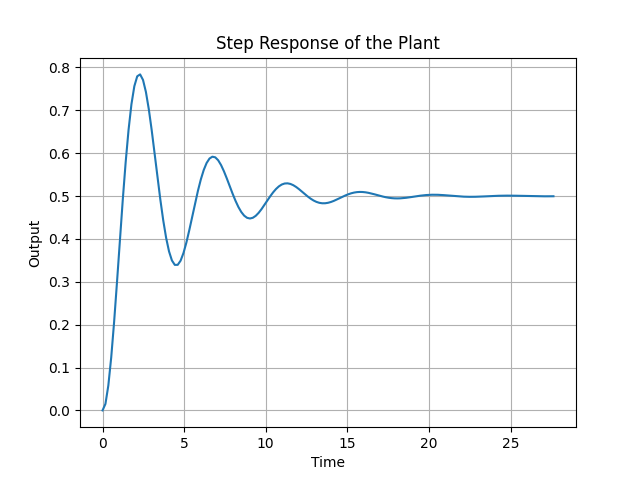

From this step response of the plant that has PID controller, it can be seens that after some oscillations, the system tends to reacha  steady-state and shows an overall stability